In [ ]:
import pandas as pd
import numpy as np

# Loading dataset and Pre-process data

In [ ]:
df = pd.read_csv("Depression_Dataset.csv")
df.head()

,text,label
0,เพราะปกติถ้ามาวัดที่โรงพยาบาลจะสูงถึงทุกครั้ง,1
1,เรากำลังจะกลับไปในจุดที่เรามีความสุขที่ได้ทำแล...,1
2,บันทึกปีศาจจิตป่วยความเสียใจที่บาดลึก,1
3,เช้าแล้วก็ยังเหมือนเดิม,1
4,ยังคงด่าทอเราได้และข่มขู่ให้เราปล่อย,1


In [ ]:
df.isnull().sum()

,0
text,0
label,0


In [ ]:
df['label'].unique()

array([1, 0])

In [ ]:
df['label'].value_counts()

,count
label,
1,16716
0,16303


# Load Tokenizer from huggingface

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('airesearch/wangchanberta-base-att-spm-uncased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
def preprocess_function(examples):
  return tokenizer(examples["text"], truncation=True)

# Train Valdation Test Split

In [ ]:
from datasets import Dataset

dataset = Dataset.from_pandas(df)

train_valid_test = dataset.train_test_split(test_size=0.3, seed=42)
train_valid = train_valid_test['train']
test_dataset = train_valid_test['test']

train_valid_split = train_valid.train_test_split(test_size=0.2, seed=42)
train_dataset = train_valid_split['train']
valid_dataset = train_valid_split['test']

from datasets import DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': valid_dataset,
    'test': test_dataset
})

tokenized_dataset = dataset_dict.map(preprocess_function, batched=True)


Map:   0%|          | 0/18490 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/4623 [00:00<?, ? examples/s]

Map:   0%|          | 0/9906 [00:00<?, ? examples/s]

# Setup Data Collator

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Load Pretrained Model for Sequence Classification

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
model = AutoModelForSequenceClassification.from_pretrained("airesearch/wangchanberta-base-att-spm-uncased", num_labels=2)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install evaluate

In [ ]:
import evaluate

accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels)
    recall = recall_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels)

    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"]

    }


In [ ]:
def model_init():
    from transformers import AutoModelForSequenceClassification
    return AutoModelForSequenceClassification.from_pretrained(
        "airesearch/wangchanberta-base-att-spm-uncased",
        num_labels=2
    )

# Define Training Arguments & Initialize Trainer

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    seed=42,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    report_to="none",
    logging_strategy="steps",
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
)

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-1719267111.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Train Model

In [ ]:
trainer.train()
trainer.save_model("./final_model")

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.542600,0.543511,0.698681,0.692591,0.724936,0.708394
2,0.462700,0.479183,0.749081,0.773023,0.712082,0.741302
3,0.399300,0.467911,0.773524,0.744027,0.840617,0.789378
4,0.347000,0.470278,0.778715,0.758784,0.823479,0.789809
5,0.352300,0.480458,0.784988,0.769726,0.819195,0.793690


# Evaluate Model

In [ ]:
val_metrics = trainer.evaluate()
val_metrics

{'eval_loss': 0.4804575443267822,
 'eval_accuracy': 0.7849881029634437,
 'eval_precision': 0.7697262479871175,
 'eval_recall': 0.8191945158526135,
 'eval_f1': 0.7936903279369033,
 'eval_runtime': 14.7516,
 'eval_samples_per_second': 313.389,
 'eval_steps_per_second': 19.591,
 'epoch': 5.0}

In [ ]:
test_metrics = trainer.evaluate(tokenized_dataset["test"])
test_metrics

{'eval_loss': 0.4536024332046509,
 'eval_accuracy': 0.7995154451847365,
 'eval_precision': 0.7863524044858392,
 'eval_recall': 0.8275655131026205,
 'eval_f1': 0.8064327485380117,
 'eval_runtime': 30.527,
 'eval_samples_per_second': 324.499,
 'eval_steps_per_second': 20.31,
 'epoch': 5.0}

# Confusion Matrix

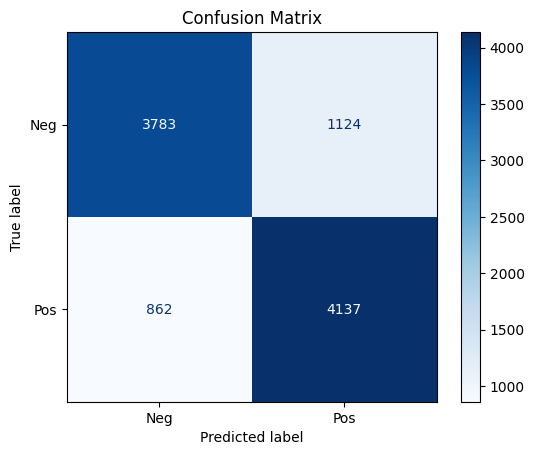

              precision    recall  f1-score   support

         Neg     0.8144    0.7709    0.7921      4907
         Pos     0.7864    0.8276    0.8064      4999

    accuracy                         0.7995      9906
   macro avg     0.8004    0.7993    0.7993      9906
weighted avg     0.8003    0.7995    0.7993      9906



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

test_output = trainer.predict(tokenized_dataset['test'])

y_pred = np.argmax(test_output.predictions, axis=1)
y_true = test_output.label_ids

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Neg", "Pos"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=["Neg", "Pos"], digits=4))


# Model Loss & Accuracy

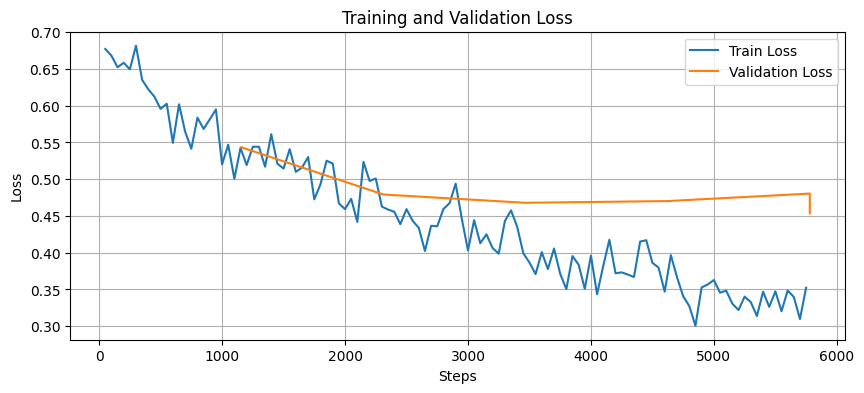

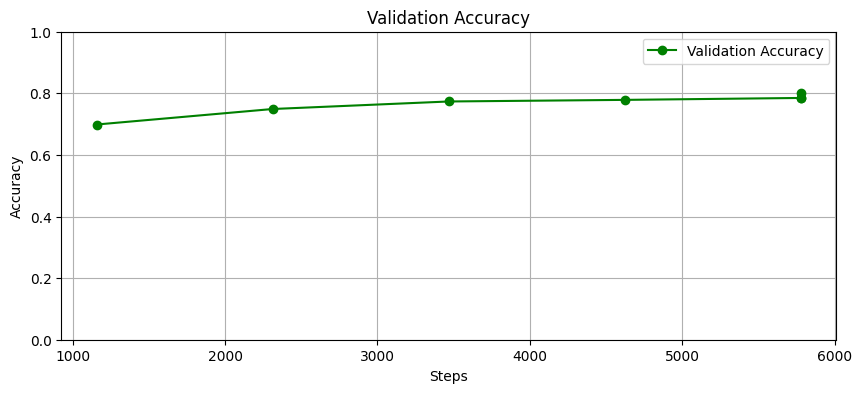

In [ ]:
train_loss, train_steps = [], []
eval_loss, eval_accuracy, eval_steps = [], [], []

for log in trainer.state.log_history:
    if "loss" in log and "eval_loss" not in log:
        train_loss.append(log["loss"])
        train_steps.append(log["step"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
        eval_steps.append(log["step"])
        if "eval_accuracy" in log:
            eval_accuracy.append(log["eval_accuracy"])

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(train_steps, train_loss, label="Train Loss")
plt.plot(eval_steps, eval_loss, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

if eval_accuracy:
    plt.figure(figsize=(10, 4))
    plt.plot(eval_steps, eval_accuracy, marker="o", label="Validation Accuracy", color="green")
    plt.xlabel("Steps")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(True)
    plt.show()


# Testing Model Generalization

In [ ]:
texts = [
    "ไม่อยากตื่นเจอวันพรุ่งนี้",
    "ฉันกำลังรักษาโรคซึมเศร้า",
    "วันนี้รู้สึกดีมาก มีความสุข",
    "ไม่มีแรงทำอะไรเลย เหนื่อยจนทนไม่ไหว",
    "ชีวิตนี้ไม่มีความหมาย",
    "เราหวังจะมีเจ้าชายออกมาจากตะเกียงหรอ",
    "หลังจากได้รับการรักษามาสักระยะ",
]

inputs = tokenizer(
    texts,
    padding=True,
    truncation=True,
    return_tensors="pt"
)

import torch
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)
    preds = torch.argmax(probs, dim=1)

for i, text in enumerate(texts):
    label = preds[i].item()
    confidence = probs[i][label].item()
    result = "เป็นโรคซึมเศร้า" if label == 1 else "ไม่เป็นโรคซึมเศร้า"
    print(f"'{text}' → {result} (ความมั่นใจ = {confidence:.2f})")


'ไม่อยากตื่นเจอวันพรุ่งนี้' → ไม่เป็นโรคซึมเศร้า (ความมั่นใจ = 0.67)
'ฉันกำลังรักษาโรคซึมเศร้า' → ไม่เป็นโรคซึมเศร้า (ความมั่นใจ = 0.53)
'วันนี้รู้สึกดีมาก มีความสุข' → ไม่เป็นโรคซึมเศร้า (ความมั่นใจ = 0.56)
'ไม่มีแรงทำอะไรเลย เหนื่อยจนทนไม่ไหว' → ไม่เป็นโรคซึมเศร้า (ความมั่นใจ = 0.60)
'ชีวิตนี้ไม่มีความหมาย' → เป็นโรคซึมเศร้า (ความมั่นใจ = 0.58)
'เราหวังจะมีเจ้าชายออกมาจากตะเกียงหรอ' → ไม่เป็นโรคซึมเศร้า (ความมั่นใจ = 0.58)
'หลังจากได้รับการรักษามาสักระยะ' → ไม่เป็นโรคซึมเศร้า (ความมั่นใจ = 0.62)
